In [1]:
import cv2
import imageio
import json
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True)

%matplotlib inline

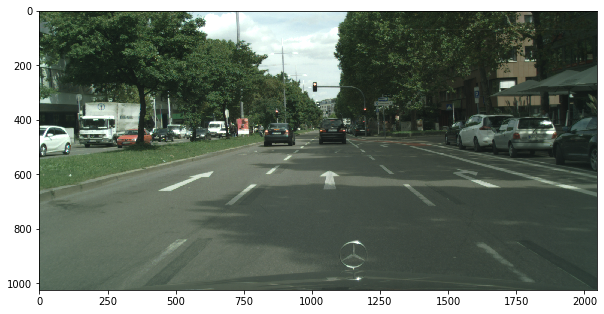

In [2]:
data_path = 'data/front_view.png'
rgb = imageio.imread(data_path)
plt.figure(figsize=(10, 10))
plt.imshow(rgb)

![alt text](coord_sys.png "Coordinates")

In [3]:
# From world to camera coordinates
camera_params_path = 'camera_params.json'
camera_params = None
with open(camera_params_path, 'r') as fh:
    camera_params = json.load(fh)
print(camera_params)

{'baseline': 0.21409619719999115, 'pitch': 0.03842560000000292, 'roll': 0.0, 'yaw': -0.009726800000000934, 'x': 1.7, 'y': 0.026239999999999368, 'z': 1.212400000000026, 'fx': 2263.54773399985, 'fy': 2250.3728170599807, 'cx': 1079.0175620000632, 'cy': 515.0066006000195}


In [4]:
b = camera_params['baseline']

K = np.array([
    [camera_params['fx'], 0.0, camera_params['cx']],
    [0.0, camera_params['fy'], camera_params['cy']],
    [0.0, 0.0, 1.0]
]).astype(np.float32)

Kinv = np.linalg.inv(K)

print(K.shape)

# theta_x (roll), theta_y (pitch), theta_z (yaw)
rotation_euler_angles = np.array([ camera_params['roll'], camera_params['pitch'], camera_params['yaw'] ])
# Rotation matrix R = Rx*Ry*Rz

t = np.array([ camera_params['x'], camera_params['y'], camera_params['z'] ])

(3, 3)


In [5]:
# pnt_cam = H_c2v*H_v2r(t)*pnt_road
def rotation_mat(euler_angles):
    theta_x, theta_y, theta_z = euler_angles
    Rz = np.array([
        np.cos(theta_z), -np.sin(theta_z), 0.0,
        np.sin(theta_z), np.cos(theta_z), 0.0,
        0.0, 0.0, 1.0,
    ]).reshape(3, 3)
    Ry = np.array([
        np.cos(theta_y), 0.0, np.sin(theta_y),
        0.0, 1.0, 0.0,
        -np.sin(theta_y), 0.0, np.cos(theta_y),
    ]).reshape(3, 3)
    Rx = np.array([
        1.0, 0.0, 0.0,
        0.0, np.cos(theta_x), -np.sin(theta_x),
        0.0, np.sin(theta_x), np.cos(theta_x),
    ]).reshape(3, 3)
    return Rz @ Ry @ Rx

In [6]:
# From car coords to camera coords: R and t
R = rotation_mat(rotation_euler_angles)
#print(R)
H = np.array([
    *R[0, :], t[0],
    *R[1, :], t[1],
    *R[2, :], t[2],
]).reshape(3, 4).astype(np.float32)

# Since, the rotation matrix is symmetric, Rinv = R.T since R.R.T = I => R.t = Rinv
R_inv = np.linalg.pinv(R)
print(R_inv)
t_inv = -t # a' = a + t => a = a' - t

[[ 0.99921456 -0.00971947 -0.03841614]
 [ 0.00972665  0.9999527  -0.        ]
 [ 0.03841433 -0.00037366  0.99926183]]


In [7]:
# From car coords to camera coords
H_v2c = np.array([
    *R_inv[0, :], t_inv[0],
    *R_inv[1, :], t_inv[1],
    *R_inv[2, :], t_inv[2]
]).reshape(3, 4).astype(np.float32)
print(H_v2c.shape)

'''
    (1) Rotate around z-axis
    (2) Rotate around x-axis
    
    Now, the coordinate system of the road/car is aligned with the one of camera
'''

theta = np.pi / 2
Rz = np.array([
    [ np.cos(theta), -np.sin(theta), 0.0 ],
    [ np.sin(theta), np.cos(theta), 0.0 ],
    [ 0.0, 0.0, 1.0 ]
])

Rx = np.array([
    [ 1.0, 0.0, 0.0 ],
    [ 0.0, np.cos(theta), -np.sin(theta) ],
    [ 0.0, np.sin(theta), np.cos(theta) ]
])

P = Rx @ Rz
print(P)
print(P.shape)

H = P @ H_v2c
print(H.shape)

(3, 4)
[[ 0. -1.  0.]
 [ 0.  0. -1.]
 [ 1.  0.  0.]]
(3, 3)
(3, 4)


In [8]:
'''
    Procedure:
        (1) Define the road plane on which to project into bev
        (2) Project from 3D to 2D ([u, v, 1].T = K . Hr2c . [Xr, Yr, Zr=0, 1].T) (this is our projection matrix P)
        (3) Rotate the axes so they match (from car to camera)
        (4) Get rgb intensity of pixel value and map 1-to-1 on the road plane (one could bilinearly sample for better results)
'''

# Desing choices:
# (1) defined by the engineer
road_side = 300
# (2) meters/pxl (obtained from calibration)
scale = 0.1

# Define our road plane (wrt vehicle): [X, -Y, Z=0, 1], given coordinate system of the vehicle (refer to diagram at begining)
road_img = np.zeros(shape=(road_side, road_side, 3)).astype(np.int32)
half = road_side // 2
# TODO: Vectorize with numpy
for row in range(-half, half):
    for col in range(0, road_side):
        # in meters (3D pnt)
        road_pnt = np.array([ col * scale, -row * scale, 0, 1]).T
        img_pnt = K @ H @ road_pnt
        img_pnt = img_pnt // (img_pnt[-1] + 1e-8)
        img_pnt = img_pnt.astype(np.int32)
        rgb_val = rgb[img_pnt[1]][img_pnt[0]] if img_pnt[0] > 0 and img_pnt[0] < rgb.shape[1] and img_pnt[1] > 0 and img_pnt[1] < rgb.shape[0] else np.zeros(shape=(3))
        # Note: Offset at 0 as it starts from -half
        road_img[row - half][col] = rgb_val

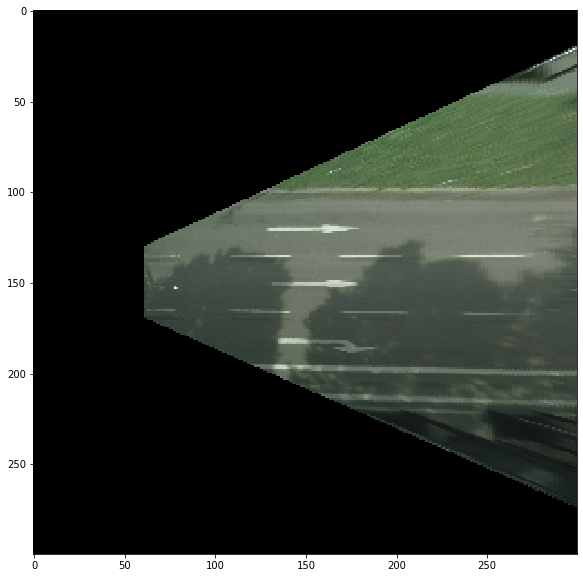

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(road_img)